In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData


from Decon import SpectralDecon
from Interpolation_Class import Interpolation

In [154]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
coreNames = CoresSpecs['CoreName']
site = 'SiteB'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]

dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
bdot0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']+273.15
dens0 = CoreSpecs['dens0']
z0 = CoreSpecs['z0']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

In [155]:
#figDiff, axDiff= plt.subplots(figsize=(6,7))
#
#sigmas = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiffVas.txt','\t')
#sigma_arr = sigmas['sigma_o18']
#z_vec = sigmas['Depth']
#
#
#sigmas2 = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiffThea.txt','\t')
#sigma_arr2 = sigmas2['sigma_o18']
#z_vec2 = sigmas2['Depth']
#
#TambDepth = dTamb
#LakiDepth = dLaki
#z_LT = z_vec[(z_vec >= TambDepth) & (z_vec <= LakiDepth)]
#sigma_LT = np.asarray(sigma_arr[(z_vec >= TambDepth) & (z_vec <= LakiDepth)])
#z_LT2 = z_vec2[(z_vec2 >= TambDepth) & (z_vec2 <= LakiDepth)]
#sigma_LT2 = np.asarray(sigma_arr2[(z_vec2 >= TambDepth) & (z_vec2 <= LakiDepth)])
#
#axDiff.invert_yaxis()
#axDiff.plot(sigma_arr,z_vec, 'b', lw=1, label = 'Vas')
#axDiff.plot(sigma_arr2,z_vec2, 'g', lw=1, label = 'Thea')
#axDiff.plot(sigma_LT,z_LT, 'k', lw=3)
#axDiff.plot(sigma_LT2,z_LT2, 'k', lw=3)
#axDiff.axhline(y = TambDepth, alpha=0.8, color='k', ls='--', lw=1.5)
#axDiff.axhline(y = LakiDepth, alpha=0.8, color='k', ls='--', lw=1.5)
#axDiff.axvline(x = sigma_LT[0], alpha=0.8, color='k', ls='--', lw=1.5)
#axDiff.axvline(x = sigma_LT[-1], alpha=0.8, color='k', ls='--', lw=1.5)
#axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]',title=f'Diffusion Length LT:({sigma_LT[0]:.3f},{sigma_LT[-1]:.3f})')
#axDiff.grid(True, color='grey',ls='-.')
#axDiff.legend()
#figDiff.tight_layout()
#

[(0.068617, 0.082668)]

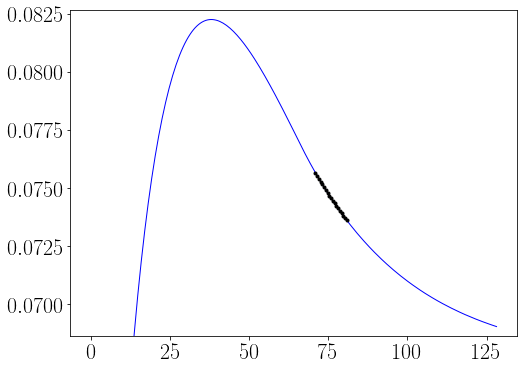

In [156]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z_vec,sigma_arr, 'b', lw=1)
ax.plot(z_LT,sigma_LT, color='k', lw=1.2, marker='.')
ax.set(ylim=(min(sigma_LT)-0.005, max(sigma_LT)+0.007))
#ax.set(xlim=(min(z_LT)-10,max(z_LT)+10))

In [157]:


# Define data under examination
x_arr = z_LT
y_arr = sigma_LT

# Define objective function 
def fct(x,a,b,c):
    return a*(x**2) + b*x + c

# Fit curve to data
from scipy.optimize import curve_fit
popt, test = curve_fit(fct, x_arr, y_arr)

a, b, c = popt

In [158]:
residuals = y_arr - fct(x_arr,*popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_arr - np.mean(y_arr))**2)
r2 = 1 - (ss_res / ss_tot)
r2

0.9999983816396835

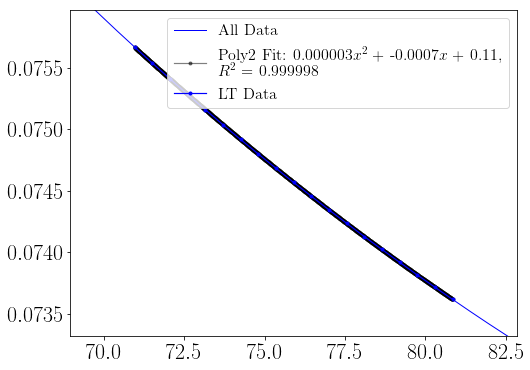

In [163]:
Npoints = 2200-1
delta = (max(z_LT) - min(z_LT))/Npoints
xTest = np.arange(min(z_LT),max(z_LT)+delta,delta)
yTest = fct(xTest, a, b, c)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(z_vec,sigma_arr, 'b', lw=1, label='All Data')
ax.plot(xTest,yTest, color='k', lw=1.2, marker='.', alpha=0.5,label=f'Poly2 Fit: {a:.6f}$x^2$ + {b:.4f}$x$ + {c:.2f}, \n$R^2$ = {r2:.6f}')
ax.plot(z_LT,sigma_LT, color='b', lw=1.2, marker='.', label='LT Data')
ax.set(ylim=(min(sigma_LT)-0.0003, max(sigma_LT)+0.0003),xlim=(min(z_LT)-2, max(z_LT)+2))
ax.legend(fontsize=16)

In [164]:
z_arr = xTest
sig_arr = yTest


In [165]:
deconInst = SpectralDecon(np.asarray(depth_LT),np.asarray(d18O_LT),2000)

In [166]:
w, Op, M, R, m= deconInst.Filters2(sig_arr, z_arr)

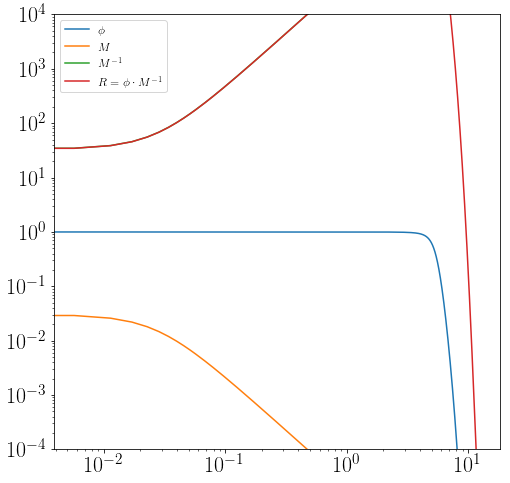

In [167]:
fig,ax = plt.subplots(figsize=(8,8))
plt.loglog(w,Op, label='$\phi$')
plt.loglog(w,M, label='$M$')
plt.loglog(w,(M)**(-1), label='$M^{-1}$')
plt.loglog(w,R, label='$R = \phi\cdot M^{-1}$')
plt.gca().set_ylim((1e-4,1e4))
plt.legend(fontsize=12)

In [168]:
sig_arr

array([0.07566669, 0.07566562, 0.07566456, ..., 0.07361972, 0.07361893,
       0.07361813])

In [169]:
d, test = deconInst.deconvolve(sig_arr, z_arr)
d1, test1 = deconInst.deconvolve(sigma=np.mean(sig_arr))

In [170]:
from scipy import signal

print(f'N peaks, sigma = const: {len(signal.find_peaks(test1)[0])}')
print(f'N peaks, sigma = sigma(z): {len(signal.find_peaks(test)[0])}')

N peaks, sigma = const: 35
N peaks, sigma = sigma(z): 34


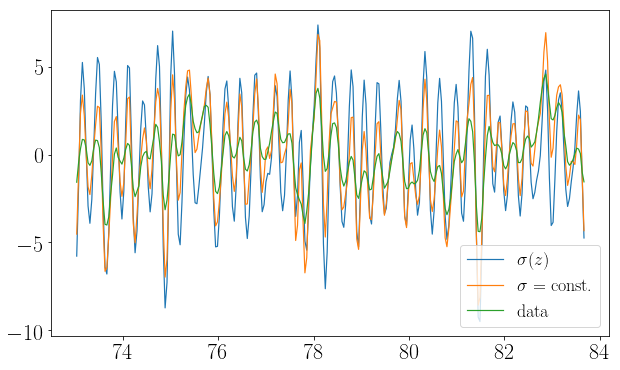

In [172]:
fig,ax=plt.subplots(figsize=(10,6))
plt.plot(d,test/100000, label='$\sigma(z)$', lw=1.2)
#plt.plot(d1,test1, label='$\sigma = $ const.', lw=1.2)
plt.plot(depth_LT,d18O_LT-np.mean(d18O_LT), label='data', lw=1.2)
plt.legend(fontsize=18)

In [145]:
g_arr = np.exp(-z_arr**2/(2*(sig_arr*100)*2))
g = 1/sum(g_arr) * g_arr


In [21]:
N = len(z_arr)
dt = np.mean(np.diff(z_arr))
freq = np.fft.fftfreq(2*N, dt)[:(2*N)//2]
freq

array([0.00000000e+00, 5.04801957e-02, 1.00960391e-01, ...,
       1.02424317e+02, 1.02474797e+02, 1.02525277e+02])

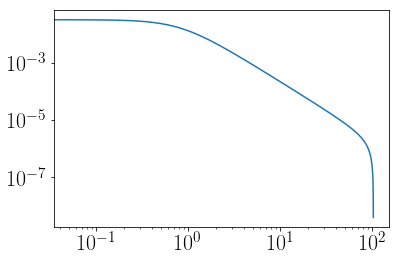

In [22]:
G = sp.fft.dct(g, 2, norm='ortho')
M = np.exp(-(2 * np.pi * freq)**2 * np.mean(sig_arr)**2 / 2)
plt.loglog(freq,G)


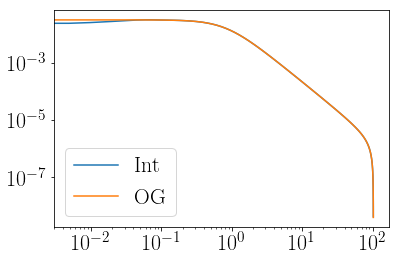

In [23]:
Gspline = sp.interpolate.interp1d(freq,G,kind='cubic')

Npoints = 2032
dz = (max(z_arr) - min(z_arr))/Npoints
freqNew = np.arange(min(freq), max(freq), dz)

Gint = Gspline(freqNew)
plt.loglog(freqNew, Gint, label='Int')
plt.loglog(freq,G,label='OG')
plt.legend()

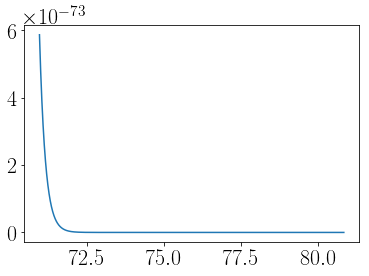

In [24]:
plt.plot(z_arr,g_arr)

In [25]:
z_arr[0]sig_arr

SyntaxError: invalid syntax (<ipython-input-25-669ad38efb49>, line 1)

In [26]:
np.exp(-z_arr**2/(2*(7)**2))

array([4.91899921e-23, 4.88440197e-23, 4.85004571e-23, ...,
       1.09395810e-29, 1.08519565e-29, 1.07650286e-29])